<a href="https://colab.research.google.com/github/mir7942/CDE2021_TransferLearning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 튜토리얼: 전이학습을 이용한 이미지 분류

이번 실습에서는 전이학습(transfer learning)을 이용해 이미지를 분류해 보겠습니다.

**이번 실습에서는 GPU를 이용합니다. 이를 위해서는 메뉴의 [런타임]-[런타임 유형 변경]에서 '하드웨어 가속기'를 'GPU'로 선택해야 합니다.**

실습에 사용할 이미지셋은 Kaggle의 [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) 입니다. 분류 목적은 이미지가 주어졌을 때, 해당 이미지가 개(dog=1)인지 고양이(cat=0)인지 구분하는 것입니다. 이는 전형적인 이진 분류(binary classification) 문제입니다.

우선 필요한 모듈을 불러옵니다.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 데이터셋 준비
Dogs vs. Cats 데이터셋을 불러오기 위해 Tensorflow Datasets를 이용합니다. 이 데이터셋에는 train 이미지만 들어있기 때문에, 이를 60:20:20의 비율로 학습셋, 검증셋, 테스트셋으로 분할합니다.

In [ ]:
original_train_set, original_validation_set, original_test_set = tfds.load('cats_vs_dogs', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], as_supervised=True)
CLASSES = ['CAT', 'DOG']  # 레이블을 나타내는 문자열

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0M9DOE/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


불러온 데이터셋의 정보를 확인합니다. 출력된 이미지를 보면, 각각의 이미지가 다른 크기를 갖고 있는 것을 확인할 수 있습니다.

Train set: 13957
Validation set: 4653
Test set: 4652


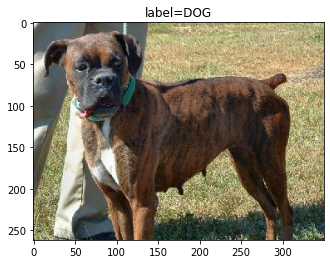

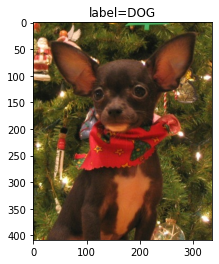

In [ ]:
count_train_set = tf.data.experimental.cardinality(original_train_set).numpy() # 데이터셋의 개수
count_validation_set = tf.data.experimental.cardinality(original_validation_set).numpy() # 데이터셋의 개수
count_test_set = tf.data.experimental.cardinality(original_test_set).numpy() # 데이터셋의 개수

print("Train set:", count_train_set)
print("Validation set:", count_validation_set)
print("Test set:", count_test_set)

for (image, label) in original_train_set.take(2):  # 데이터셋에서 2개의 데이터를 가져온다.
  plt.figure()
  plt.imshow(image)
  plt.title('label=' + CLASSES[label.numpy()])

학습에 사용할 수 있게 데이터셋을 준비합니다.
1.   Dogs vs. Cats의 픽셀 타입은 int이므로 이를 float으로 변경합니다.
2.   Dogs vs. Cats 픽셀값의 범위는 [0, 255] 이므로, 각 픽셀값을 [-1, 1]이 되도록 정규화합니다.
3.   모든 이미지 크기를 동일하게 조정합니다. 여기서는 (150, 150)으로 통일합니다.

In [ ]:
IMAGE_SIZE = 150

def format_image(image, label):
  image = tf.cast(image, tf.float32) # 이미지 픽셀 타입을 float으로 변경
  image = (image/127.5) - 1 # 이미지 픽셀값의 범위를 -1~1로 조정
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # 이미지 크기를 조정
  return image, label

train_set = original_train_set.map(format_image) # 데이터셋에 format_image() 함수 적용
validation_set = original_validation_set.map(format_image) # 데이터셋에 format_image() 함수 적용
test_set = original_test_set.map(format_image) # 데이터셋에 format_image() 함수 적용

변경된 이미지의 크기를 확인해 봅니다.

In [ ]:
for (image, label) in train_set.take(2):
  print(image.numpy().shape)

(150, 150, 3)
(150, 150, 3)


학습을 위해 데이터셋을 배치 단위로 나누고 섞습니다.

In [ ]:
BATCH_SIZE = 32 # 미니배치 크기
SHUFFLE_BUFFER_SIZE = 1000 # 섞을 때 사용할 버퍼 크기

train_batches = train_set.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # 이미지를 섞고, 배치 단위로 나눈다.
validation_batches = validation_set.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # 이미지를 배치 단위로 나눈다.
test_batches = test_set.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # 이미지를 배치 단위로 나눈다.

## 모델 변경(전략 2): 분류 계층만 재학습
우선 모델의 분류 계층만 재학습하는 것을 실습해 보겠습니다.

### 모델 불러오기
이번 실습에서는 사전학습된 VGG16 모델을 불러와 사용하도록 하겠습니다. 그러나 어떤 모델을 사용하던 과정은 동일합니다. Tensorflow에서 지원하는 사전학습 모델은 [여기](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko)에서 확인할 수 있습니다.

In [ ]:
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# 모델을 불러온다.
base_model2 = tf.keras.applications.VGG16(
    weights="imagenet",  # ImageNet에 대해 학습한 가중치를 불러온다.
    input_shape=IMAGE_SHAPE, # 입력 노드의 모양
    include_top=False, # 최상위 노드(classification 레이어)를 포함하지 않는다.
)  

58900480/58889256 [==============================] - 1s 0us/step


불러온 모델 정보를 확인합니다. 입력 레이어(input_1)의 크기가 (150, 150, 3)인 것을 확인할 수 있고, 가장 마지막 레이어(block5_pool)가 MaxPooling2D인 것을 확인할 수 있습니다.

In [ ]:
base_model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 모델 변경
새로 학습할 데이터셋에 맞게 입력층과 분류기를 추가합니다.

이번 실습에서는 분류기로 GAP(global averge pooling) 레이어를 사용합니다. 그리고 이진 분류를 위해 sigmoid 활성화 함수를 사용합니다.

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE) # 입력층
x = base_model2(inputs, training=False) # training=False는 학습이 아닌 추정 모드로 작동하도록 한다.
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Classification을 위한 레이어. 여기서는 GAP를 사용한다.
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # 이진 분류를 위한 출력층

model2 = tf.keras.Model(inputs, outputs)

이번 실습에서는 새로 추가한 분류기 부분만 재학습 합니다. 따라서 사전학습된 부분은 학습이 되지 않도록 합니다. 이는 모델의 trainable 변수값을 False로 설정하면 가능합니다.

변경된 모델을 보면, "Trainable params"가 513개로 매주 적어진 것을 확인할 수 있습니다.

In [ ]:
base_model2.trainable = False # 학습 시, 가중치가 변경되지 않도록 동결(freeze)한다.
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


### 학습 및 평가
학습을 시작합니다. 재학습을 할 때는 많이 할 필요가 업습니다. 여기서는 5번만 반복합니다.

In [ ]:
EPOCHS = 5
LEARNING_RATE = 0.001

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model2.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/5
437/437 [==============================] - 80s 103ms/step - loss: 0.3589 - binary_accuracy: 0.8804 - val_loss: 0.2595 - val_binary_accuracy: 0.9117
Epoch 2/5
437/437 [==============================] - 39s 90ms/step - loss: 0.2309 - binary_accuracy: 0.9162 - val_loss: 0.2145 - val_binary_accuracy: 0.9233
Epoch 3/5
437/437 [==============================] - 40s 92ms/step - loss: 0.2010 - binary_accuracy: 0.9231 - val_loss: 0.1942 - val_binary_accuracy: 0.9231
Epoch 4/5
437/437 [==============================] - 40s 91ms/step - loss: 0.1855 - binary_accuracy: 0.9286 - val_loss: 0.1820 - val_binary_accuracy: 0.9274
Epoch 5/5
437/437 [==============================] - 40s 92ms/step - loss: 0.1759 - binary_accuracy: 0.9291 - val_loss: 0.1747 - val_binary_accuracy: 0.9302


테스트셋을 이용해 학습한 모델을 평가합니다.

In [ ]:
score = model2.evaluate(test_batches)
    
print("Test loss:", score[0])
print("Test accuracy:", score[1])

146/146 [==============================] - 13s 85ms/step - loss: 0.1673 - binary_accuracy: 0.9340
Test loss: 0.1672765016555786
Test accuracy: 0.9340068697929382


### 미세조정
재학습한 모델을 미세조정하여 정확도를 높일 수 있습니다. 이 때는, learning rate를 좀 더 낮추고, 전체 모델을 학습합니다.

In [ ]:
base_model2.trainable = True # 전체 모델을 학습합니다.
model2.summary() # 학습 파라미터의 수가 증가한 것을 확인할 수 있습니다.

EPOCHS_TUNING = 5
LEARNING_RATE_TUNING = 0.00001 # 처음 학습할 때보다 작게 합니다.

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TUNING),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model2.fit(train_batches, epochs=EPOCHS_TUNING, validation_data=validation_batches)

score_tuning = model2.evaluate(test_batches)
    
print("Test loss:", score_tuning[0])
print("Test accuracy:", score_tuning[1])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
437/437 [==============================] - 108s 236ms/step - loss: 0.0944 - binary_accuracy: 0.9625 - val_loss: 0.0660 - val_binary_accuracy: 0.9759
Epoch 2/5
437/437 [==============================] - 102s 233ms/step - loss: 0.0389 - bi

## 모델 변경(전략 3): 컨볼루션 레이어 일부와 분류 계층 재학습
이번에는 VGG16의 컨볼루션 레이어 일부까지 재학습 해보도록 하겠습니다. 여기서 재학습할 레이어는 block5_conv3 으로 하겠습니다.

### 모델 불러오기
우선 VGG16 모델을 다시 불러옵니다.

In [ ]:
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# 모델을 불러온다.
base_model3 = tf.keras.applications.VGG16(
    weights="imagenet",  # ImageNet에 대해 학습한 가중치를 불러온다.
    input_shape=IMAGE_SHAPE, # 입력 노드의 모양
    include_top=False, # 최상위 노드(classification 레이어)를 포함하지 않는다.
)  

### 모델 변경
새로 학습할 데이터셋에 맞게 입력층과 분류기를 추가합니다.

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE) # 입력층
x = base_model3(inputs, training=False) # training=False는 학습이 아닌 추정 모드로 작동하도록 한다.
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Classification을 위한 레이어. 여기서는 GAP를 사용한다.
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # 이진 분류를 위한 출력층

model3 = tf.keras.Model(inputs, outputs)

모델의 일부 레이어(block5_conv3)만 학습되도록 변경합니다.

In [ ]:
base_model3.trainable = True
trainable_layer_names = ['block5_conv3']

for layer in base_model3.layers:
  if layer.name in trainable_layer_names:
    layer.trainable = True
  else:
    layer.trainable = False

model3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 2,360,321
Non-trainable params: 12,354,880
_________________________________________________________________


### 학습 및 평가
학습을 시작합니다.

In [ ]:
EPOCHS = 5
LEARNING_RATE = 0.001

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model3.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

score = model3.evaluate(test_batches)
    
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5
437/437 [==============================] - 42s 94ms/step - loss: 0.1912 - binary_accuracy: 0.9204 - val_loss: 0.1275 - val_binary_accuracy: 0.9527
Epoch 2/5
437/437 [==============================] - 41s 95ms/step - loss: 0.1082 - binary_accuracy: 0.9559 - val_loss: 0.1313 - val_binary_accuracy: 0.9504
Epoch 3/5
437/437 [==============================] - 41s 95ms/step - loss: 0.0785 - binary_accuracy: 0.9715 - val_loss: 0.1311 - val_binary_accuracy: 0.9519
Epoch 4/5
437/437 [==============================] - 41s 95ms/step - loss: 0.0506 - binary_accuracy: 0.9823 - val_loss: 0.1843 - val_binary_accuracy: 0.9345
Epoch 5/5
146/146 [==============================] - 10s 67ms/step - loss: 0.1275 - binary_accuracy: 0.9574
Test loss: 0.12749724090099335
Test accuracy: 0.9574376344680786


### 미세조정
재학습한 모델을 미세조정하여 정확도를 높입니다.

In [ ]:
base_model3.trainable = True # 전체 모델을 학습합니다.
model3.summary() # 학습 파라미터의 수가 증가한 것을 확인할 수 있습니다.

EPOCHS_TUNING = 5
LEARNING_RATE_TUNING = 0.00001 # 처음 학습할 때보다 작게 합니다.

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TUNING),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model3.fit(train_batches, epochs=EPOCHS_TUNING, validation_data=validation_batches)

score_tuning = model3.evaluate(test_batches)
    
print("Test loss:", score_tuning[0])
print("Test accuracy:", score_tuning[1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
437/437 [==============================] - 102s 232ms/step - loss: 0.0293 - binary_accuracy: 0.9895 - val_loss: 0.1268 - val_binary_accuracy: 0.9598
Epoch 2/5
437/437 [==============================] - 101s 231ms/step - loss: 0.0165 - 

실습은 여기까지 입니다. 많은 도움이 되셨나요?

모델의 정확도 향상을 위해 몇 가지를 시도해 볼 수 있습니다.
1. 입력 이미지 강화 (augmentation)
2. 분류기에 dropout 레이어 추가
3. 하이퍼파라미터(hyperparameter) 최적화

**감사합니다.**
